# Creating Dataset

In [85]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import cv2
from tqdm import tqdm
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

train_df = pd.read_csv('/Users/c/Desktop/Kaggle_Study/labels.csv')
test_df = pd.read_csv('/Users/c/Desktop/Kaggle_Study/sample_submission.csv')

def get_image_train_path(x):
    path = r".\train\{}.jpg".format(x)
    return path

def get_image_test_path(x):
    path =  r".\test\{}.jpg".format(x)
    return path

test_df['path'] = test_df['id'].apply(lambda x : get_image_test_path(x))

train_df['path'] = train_df['id'].apply(lambda x : get_image_train_path(x))
train_df.drop('id', axis = 1, inplace = True)
train_df.head()


,breed,path
0,boston_bull,.\train\000bec180eb18c7604dcecc8fe0dba07.jpg
1,dingo,.\train\001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,pekinese,.\train\001cdf01b096e06d78e9e5112d419397.jpg
3,bluetick,.\train\00214f311d5d2247d5dfe4fe24b2303d.jpg
4,golden_retriever,.\train\0021f9ceb3235effd7fcde7f7538ed62.jpg


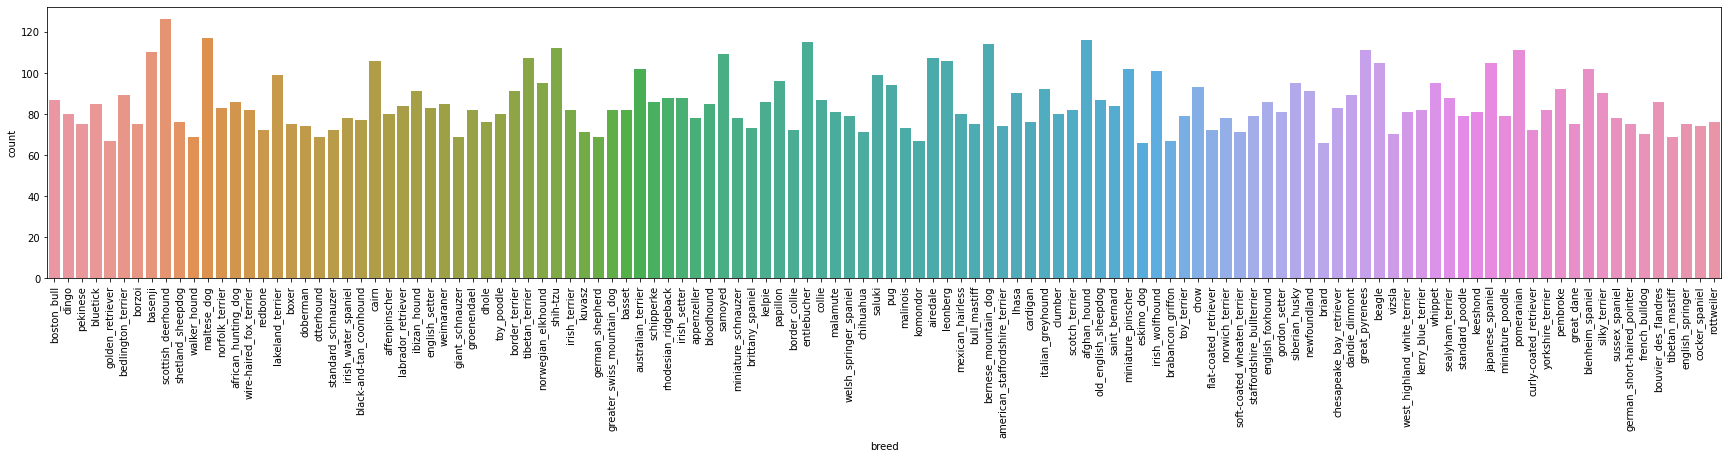

In [2]:
plt.figure(figsize = (30, 5))
sns.countplot(data = train_df ,x = 'breed')
plt.xticks(rotation = 90)
plt.show()

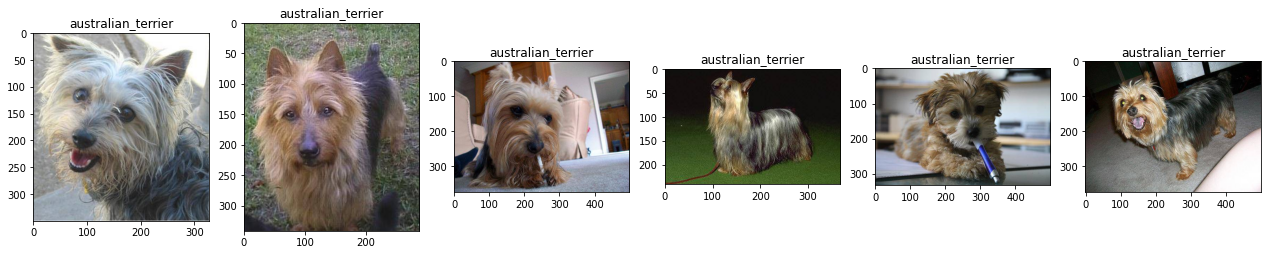

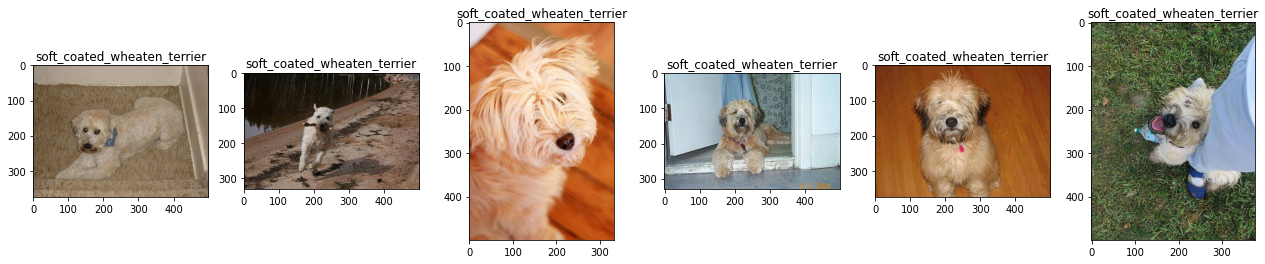

In [3]:
def show_images(image_path_list, ncols = 6, title = None):
    figure, ax = plt.subplots(figsize = (22, 4), nrows = 1, ncols = ncols)
    
    for i in range(ncols):
        tn = cv2.imread(image_path_list[i])
        image = cv2.cvtColor(tn, cv2.COLOR_BGR2RGB)
        ax[i].imshow(image)
        ax[i].set_title(title)
    
    plt.show()

australian_terrier = train_df[train_df['breed'] == 'australian_terrier']['path'].iloc[:6].tolist()
soft_coated_wheaten_terrier = train_df[train_df['breed'] == 'soft-coated_wheaten_terrier']['path'].iloc[:6].tolist()
# 데이터셋 설명에서 확인할 수 있습니다.
show_images(australian_terrier, title = 'australian_terrier')
show_images(soft_coated_wheaten_terrier, title = 'soft_coated_wheaten_terrier')

In [4]:
dog_breeds = sorted(list(set(train_df['breed'])))
n_classes = len(dog_breeds)

class_to_num = dict(zip(dog_breeds, range(n_classes)))

In [5]:
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

def images_to_array(dataframe, img_size = (224, 224, 3)):
    images_labels = dataframe['breed']
    images_path = dataframe['path'].tolist()
    data_size = len(dataframe)
    # initialize output array
    image_array = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype = np.float32)
    image_label = np.zeros([data_size, 1], dtype = np.float32)
    
    # read_image , Resize Image
    for i in tqdm(range(data_size)):
        img_pixels = load_img(images_path[i], target_size=img_size)
        
        image_array[i] = img_pixels
        image_breed = images_labels[i]
        image_label[i] = class_to_num[image_breed]
    
    image_label = to_categorical(image_label)
    # shuffle
    ind = np.random.permutation(data_size)
    image_array = image_array[ind]
    image_label = image_label[ind]
    
    print('Output Data Size : ', image_array.shape)
    print('Output Data Size : ', image_label.shape)
    
    return image_array, image_label

C:\Users\c\.conda\envs\wongi\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [6]:
train_images, train_labels = images_to_array(train_df)

100%|████████████████████████████████████████████████████████████████████████| 10222/10222 [00:31<00:00, 324.60it/s]


Output Data Size :  (10222, 224, 224, 3)
Output Data Size :  (10222, 120)


In [45]:
import tensorflow as tf
import albumentations as A
from tensorflow.keras.layers import Input, InputLayer, Dense, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Lambda, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint


def get_features(model_name, data_preprocessor, input_size, data):
    input_layer = Input(input_size)
    # CNN에서 Lambda Layer를 사용하는 경우, 사용자 정의 layer를 실행 할 수 있습니다.
    preprocessor = Lambda(data_preprocessor)(input_layer)
    if model_name == 'NASNetLarge':
        base_model = NASNetLarge(weights= 'imagenet', include_top= False, input_shape= input_size)(preprocessor)
    else:
        base_model = model_name(weights = 'imagenet', include_top = False, input_shape = input_size)(preprocessor)
    
    x = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = x)
    # Feature Extract
    feature_maps = feature_extractor.predict(data, batch_size = 64, verbose = 1)
    print('Feature Maps shape: ', feature_maps.shape)
    
    return feature_maps

In [23]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as Incep_preprocess_input
img_size = (224, 224, 3)
inception_preprocessor = Incep_preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, train_images)

160/160 [==============================] - 9s 52ms/step
Feature Maps shape:  (10222, 2048)


In [24]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xcep_preprocess_input
xception_preprocessor = Xcep_preprocess_input
xception_features = get_features(Xception, 
                                 xception_preprocessor, 
                                 img_size, 
                                 train_images)

160/160 [==============================] - 16s 96ms/step
Feature Maps shape:  (10222, 2048)


In [47]:
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input as Nas_preprocess_input 

nas_preprocess = Nas_preprocess_input
nasnet_features = get_features(NASNetMobile,
                                     nas_preprocess,
                                     img_size,
                                     train_images
)

160/160 [==============================] - 14s 71ms/step
Feature Maps shape:  (10222, 1056)


In [30]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as Eff_preprocess_input

efficientnet_preprocessor = Eff_preprocess_input
efficientnet_features = get_features(EfficientNetB0,
                                     Eff_preprocess_input,
                                     img_size,
                                     train_images
)

160/160 [==============================] - 11s 60ms/step
Feature Maps shape:  (10222, 1280)


In [34]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as ResNet_preprocess_input

ResNet_preprocessor = ResNet_preprocess_input
ResNet_features = get_features(InceptionResNetV2,
                               ResNet_preprocessor,
                               img_size,
                               train_images)

160/160 [==============================] - 24s 136ms/step
Feature Maps shape:  (10222, 1536)


In [80]:
final_features = np.concatenate([inception_features, 
                                 xception_features, 
                                 ResNet_features,
                                 efficientnet_features,
                                nasnet_features], axis = -1)
print('Final Features : ', final_features.shape)

Final Features :  (10222, 7968)


In [81]:
ely_cb = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)
lr02_cb = LearningRateScheduler(lrfn_02, verbose = 1)

dnn = Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation = 'softmax')
])

dnn.compile(optimizer=Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = dnn.fit(final_features, 
                  train_labels, 
                  batch_size = 128, 
                  epochs = 60, 
                  validation_split= 0.1, 
                  callbacks=[ely_cb])

Epoch 1/60
72/72 [==============================] - 0s 4ms/step - loss: 1.3330 - accuracy: 0.6974 - val_loss: 0.5643 - val_accuracy: 0.8495
Epoch 2/60
72/72 [==============================] - 0s 3ms/step - loss: 0.4879 - accuracy: 0.8614 - val_loss: 0.5712 - val_accuracy: 0.8514
Epoch 3/60
72/72 [==============================] - 0s 3ms/step - loss: 0.3872 - accuracy: 0.8857 - val_loss: 0.5983 - val_accuracy: 0.8436
Epoch 4/60
72/72 [==============================] - 0s 3ms/step - loss: 0.2994 - accuracy: 0.9040 - val_loss: 0.6575 - val_accuracy: 0.8407
Epoch 5/60
72/72 [==============================] - 0s 3ms/step - loss: 0.2379 - accuracy: 0.9215 - val_loss: 0.6262 - val_accuracy: 0.8397
Epoch 6/60
72/72 [==============================] - 0s 3ms/step - loss: 0.2094 - accuracy: 0.9302 - val_loss: 0.6109 - val_accuracy: 0.8592
Epoch 7/60
72/72 [==============================] - 0s 3ms/step - loss: 0.1861 - accuracy: 0.9366 - val_loss: 0.6630 - val_accuracy: 0.8573
Epoch 8/60
72/72 [==

In [86]:
def images_to_array2(dataframe, img_size = (224,224,3)):
    images_names = dataframe['id']
    data_size = len(images_names)
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype = np.float32)
    
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_pixels = tf.keras.preprocessing.image.load_img(dataframe['path'][i], target_size=img_size)
        X[i] = img_pixels
        
    print('Ouptut Data Size: ', X.shape)
    return X

test_data = images_to_array2(test_df, img_size)

100%|████████████████████████████████████████████████████████████████████████| 10357/10357 [00:32<00:00, 315.57it/s]

Ouptut Data Size:  (10357, 224, 224, 3)


In [87]:
inception_features = get_features(InceptionV3, Incep_preprocess_input, img_size, test_data)
xception_features = get_features(Xception, Xcep_preprocess_input, img_size, test_data)
ResNet_features = get_features(InceptionResNetV2, ResNet_preprocess_input, img_size, test_data)
efficientnet_features = get_features(EfficientNetB0, Eff_preprocess_input, img_size, test_data)
nasnet_features = get_features(NASNetMobile, Nas_preprocess_input, img_size, test_data)

test_features = np.concatenate([inception_features,
                                 xception_features,
                                 ResNet_features,
                                 efficientnet_features,
                                 nasnet_features], axis = -1)
print('Final feature maps shape', test_features.shape)

162/162 [==============================] - 10s 59ms/step
Feature Maps shape:  (10357, 2048)
162/162 [==============================] - 17s 101ms/step
Feature Maps shape:  (10357, 2048)
162/162 [==============================] - 25s 140ms/step
Feature Maps shape:  (10357, 1536)
162/162 [==============================] - 11s 61ms/step
Feature Maps shape:  (10357, 1280)
162/162 [==============================] - 13s 67ms/step
Feature Maps shape:  (10357, 1056)
Final feature maps shape (10357, 7968)


In [88]:
y_pred = dnn.predict(test_features, batch_size=128)

In [93]:
sample_df = pd.read_csv('/Users/c/Desktop/Kaggle_Study/sample_submission.csv')

for b in dog_breeds:
    sample_df[b] = y_pred[:,class_to_num[b]]
sample_df.to_csv('pred.csv', index=None)

In [92]:
sample_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.831284e-07,1.170396e-07,7.204958e-09,6.901174e-10,5.304180e-09,1.064293e-09,1.371494e-09,7.722808e-09,3.183848e-09,...,6.622547e-09,3.234002e-07,5.322025e-09,1.702378e-09,6.027804e-09,4.668484e-09,2.235895e-09,2.958308e-09,1.756787e-08,1.890139e-08
1,00102ee9d8eb90812350685311fe5890,1.533264e-08,2.736029e-09,4.229416e-09,2.218791e-09,2.463081e-08,4.674713e-08,5.747931e-09,1.456638e-08,1.120314e-09,...,3.840841e-09,5.394640e-08,1.247203e-08,1.020611e-08,2.019547e-08,2.060447e-09,5.600571e-07,4.791706e-09,1.633489e-09,4.239676e-08
2,0012a730dfa437f5f3613fb75efcd4ce,2.132989e-06,1.309549e-03,4.916522e-06,2.317988e-07,4.310718e-07,3.285494e-07,1.381989e-07,1.516438e-07,1.675257e-05,...,6.918408e-08,8.935675e-06,1.361867e-06,6.076099e-06,1.202723e-05,3.559773e-06,3.682895e-06,4.126236e-06,1.114190e-05,4.286997e-07
3,001510bc8570bbeee98c8d80c8a95ec1,1.079223e-02,1.344597e-04,4.045802e-04,4.761914e-07,8.169467e-05,3.378523e-05,3.219037e-07,1.346647e-05,7.454842e-06,...,1.168445e-06,3.401762e-05,3.300486e-05,1.753249e-06,2.414862e-05,8.613343e-07,1.170654e-06,7.442699e-05,8.900223e-08,1.698871e-04
4,001a5f3114548acdefa3d4da05474c2e,3.151174e-04,6.145098e-05,5.222890e-06,7.259208e-08,4.735449e-07,6.179312e-07,2.607402e-06,2.776095e-06,1.155033e-06,...,5.863358e-07,2.373273e-06,5.029872e-07,6.211241e-07,8.042681e-07,6.851180e-08,8.432887e-07,7.480492e-07,2.937090e-07,4.703884e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,2.006989e-07,4.752163e-05,7.167195e-07,1.428221e-07,8.339208e-07,1.577822e-07,5.043898e-08,1.141366e-07,5.983916e-07,...,8.479722e-05,8.670565e-06,5.367238e-07,1.040967e-06,1.173172e-06,6.863395e-07,3.995848e-08,3.822945e-07,1.136446e-06,1.897969e-07
10353,fff1ec9e6e413275984966f745a313b0,2.904290e-08,1.106562e-07,6.462254e-07,1.996708e-07,1.917640e-05,1.248524e-07,3.157812e-07,5.448454e-08,1.394757e-06,...,2.772425e-08,1.036843e-06,2.395547e-03,1.261305e-07,9.958816e-01,7.287333e-08,3.421229e-08,1.528470e-06,1.948996e-07,1.646802e-06
10354,fff74b59b758bbbf13a5793182a9bbe4,1.556645e-07,7.464931e-07,4.812732e-05,5.039968e-09,1.047595e-07,2.412354e-07,4.453065e-07,9.669352e-07,3.376699e-07,...,3.766722e-08,1.653015e-06,8.637306e-08,5.143150e-08,8.590449e-08,1.240814e-06,1.709803e-08,1.547710e-07,8.985900e-08,3.203241e-07
10355,fff7d50d848e8014ac1e9172dc6762a3,7.896616e-05,1.965039e-05,3.217976e-06,1.418170e-07,8.455180e-07,4.021221e-07,7.492258e-06,2.565824e-06,6.212828e-06,...,4.645348e-05,8.711386e-06,2.052530e-06,5.849332e-07,2.899068e-06,3.074337e-07,8.921023e-06,4.356781e-07,2.181815e-06,1.620984e-04
